In [1]:
%matplotlib inline

In [2]:
import numpy as np
import xarray as xr
import pandas as pd

import scipy.spatial
import scipy.linalg
import scipy as sp
from scipy import signal
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.sandbox.stats.multicomp as smm
import statsmodels.tsa.stattools as tsa
import statsmodels.tsa.arima_model as arima
from statsmodels.stats.diagnostic import acorr_ljungbox as ljungbox

import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
import matplotlib.pyplot as plt
import seaborn as sns
current_palette = sns.color_palette("hls", 8)
sns.set_palette(current_palette)

In [3]:
#plt.style.available

In [4]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    matplotlib.rc("font", family="Times New Roman")

In [5]:
set_style()

In [6]:
# Load the data
# wget ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G10010/G10010_SIBT1850_v1.1.zip
nc = xr.open_dataset('../data/G10010_SIBT1850_v1.1.nc')

In [7]:
# Average out years
yr_avg = nc.seaice_conc.groupby('time.year').mean()

# Separate into seasons
seasons = nc.seaice_conc.groupby('time.season').mean('latitude').mean('longitude')
seas_df = seasons.to_dataframe()
seas_df = seas_df.groupby([lambda x: x.year, 'season']).mean()
seas_df = seas_df.reset_index()

djf_df = seas_df.loc[seas_df['season'] == 'DJF']
jja_df = seas_df.loc[seas_df['season'] == 'JJA']
mam_df = seas_df.loc[seas_df['season'] == 'MAM']
son_df = seas_df.loc[seas_df['season'] == 'SON']

djf_df.reset_index(inplace=True)
jja_df.reset_index(inplace=True)
mam_df.reset_index(inplace=True)
son_df.reset_index(inplace=True)

del djf_df['index']
del jja_df['index']
del mam_df['index']
del son_df['index']

djf_df.columns = ['year', 'season', 'seaice_conc']
jja_df.columns = ['year', 'season', 'seaice_conc']
mam_df.columns = ['year', 'season', 'seaice_conc']
son_df.columns = ['year', 'season', 'seaice_conc']

del djf_df['season']
del jja_df['season']
del mam_df['season']
del son_df['season']

In [9]:
seasons = ['JJA', 'SON', 'DJF', 'MAM']
dfs = {'DJF': djf_df, 'JJA': jja_df, 'MAM': mam_df, 'SON': son_df}

In [10]:
cmap = {'JJA': 'crimson', 'SON': 'darkorange', 'DJF': 'steelblue', 'MAM': 'seagreen'}

## Arctic splines

Since the arctic sea data set is such a long time series, we'll compute linear splines to get a piecewise trend of the data.

#### Definitions:

* A **linear spline** is a continuous function formed by connecting linear
segments.  The points where the segments connect are called the
**knots** of the spline.

* A **spline of degree** $D$ is a function formed by connecting polynomial segments
of degree $D$ so that:
    * the function is continuous,
    * the function has $D-1$ continuous derivatives,
    * the $D^{\text{th}}$ derivative is constant between knots

* The **truncated polynomial** of degree $D$ associated with knot $\xi_{k}$ is the function which is equal to $0$ to the left of $\xi_{k}$ and equal to $(x-\xi_{k})^D$ to the right of $\xi_{k}$.

$$(x-\xi_{k})_{+}^D = 
\begin{cases}
(x-\xi_{k})^D, & \text{if $x \geq \xi_{k}$} \\
0, & \text{if $x \lt \xi_{k}$}
\end{cases}
$$


#### Equation of spline of degree $D=1$ and $K$ knots:

$$y = \beta_{0} + \beta_{1}x + \sum_{k=1}^{K}b_{k}(x-\xi_{k})_{+}$$

#### Design Matrix:
$$
\mathbf{X} = 
\begin{bmatrix}
1 & x_1 & (x_{1}-\xi_{1})_{+} & \dots & (x_{1}-\xi_{K})_{+} \\
1 & x_2 & (x_{2}-\xi_{1})_{+} & \dots & (x_{2}-\xi_{K})_{+} \\
\vdots & \vdots  & \vdots & \ddots & \vdots \\
1 & x_n  & (x_{n}-\xi_{1})_{+} & \dots & (x_{n}-\xi_{K})_{+}
\end{bmatrix}
$$

In [11]:
def linear_splines(data, knots, degree=1):
    minyr = data.year.min()
    nyrs = data.year.shape[0]

    # Use indices of years for knots
    minyr = data.year.min()
    knots2 = [k-minyr for k in knots]
    
    # Column vector for beta1 are (t1, t2,...,tn)
    X1 = np.arange(nyrs)
    X1 = X1[:, np.newaxis]
    
    # Generate design matrix
    X2 = np.zeros((nyrs, len(knots2)))
    for col, k in enumerate(knots2):
        X2[k:, col] = np.abs(X2[k:, col] - X1[:nyrs-k, 0])
    X = np.hstack((X1, X2))
    return smf.glm('seaice_conc ~ X', data=data).fit()

### Knots for Arctic sea

From the explore_seaice notebook, the trends look peicewise with possible knots at various locations. We'll define our set of knots for each season:

$$
K_{\text{JJA}} = \{1917, 1944, 1996\}\\
K_{\text{SON}} = \{1917, 1943, 1996\}\\
K_{\text{DJF}} = \{1974, 1996\}\\
K_{\text{MAM}} = \{1933, 1979\}
$$

We'll plot the knots to visually check

In [12]:
#from pyearth import Earth

In [13]:
# Define the knots
jjaknots = [1935, 1943, 1963,1979, 1997]
sonknots = [1915, 1950, 1979, 1997]
djfknots = [1935, 1944, 1979, 1997]
mamknots = [1896, 1929, 1935, 1953, 1979, 1997]

splines = {'JJA': linear_splines(jja_df, jjaknots),
           'SON': linear_splines(son_df, sonknots),
           'DJF': linear_splines(djf_df, djfknots),
           'MAM': linear_splines(mam_df, mamknots)}

In [14]:
def plot_splines(yrs, conc, preds, label, season=None, ax=None, col='g'):
    if ax is None:
        ax = plt.gca()
    spl = ax.plot(yrs, conc, label='data', color='k', linestyle=':')
    ax.plot(yrs, preds, label=label, color=col, linewidth=2.5)
    #ax.legend(loc="upper left")
    ax.legend(bbox_to_anchor=(.95,0.8), loc='upper left', fontsize=14)
    ax.set_xlim(1845, 2016)
    #ax.set_ylim(17.5, 26)
    ax.set_xlabel(r'Year', fontsize=17)
    ax.set_ylabel(r'Sea Ice Concentration [\%]', fontsize=17)
    title = 'Linear Splines Trend for {}'.format(season)
    ax.set_title(r'\textbf{' + title + '}', fontsize=19)
    ax.set_xticks(np.linspace(1850, 2013, 9, dtype=int))
    #yticks = np.linspace(min(preds), max(preds), 6)
    #ax.set_yticks(np.round(yticks, 2))
    ax.xaxis.set_tick_params(labelsize=13)
    ax.yaxis.set_tick_params(labelsize=13)
    return spl

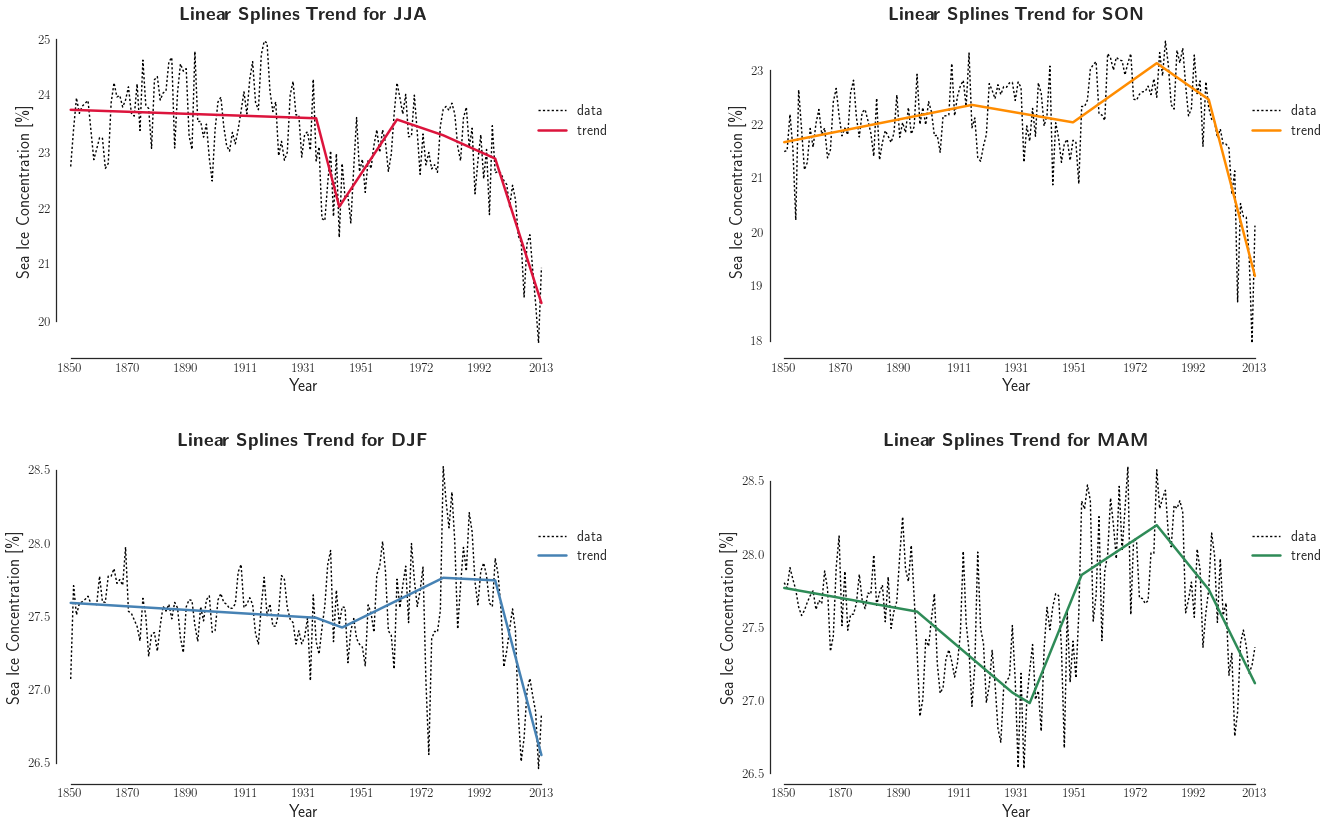

In [15]:
f, axs = plt.subplots(2, 2, figsize=(20,12))
sns.set_style("ticks")
axs = np.array(axs)
for i, ax in enumerate(axs.reshape(-1)):
    s = seasons[i]
    yr = dfs[s].year
    conc = dfs[s].seaice_conc
    preds = splines[s].fittedvalues
    plot_splines(yr, conc, preds, 'trend', season=s, ax=ax, col=cmap[s])
    
plt.subplots_adjust(wspace=20, hspace=5)
plt.tight_layout()
sns.despine(trim=True)

Visually the splines look reasonable. However, let's test the significance of each spline and remove the splines that are not significicant with a significance level, $\alpha = 0.05$

We'll use Bonferroni's correction for multiple tests.

In [16]:
#splines['JJA'].summary()

In [17]:
#f = splines['JJA']

In [18]:
#f.resid_response.values

In [19]:
nyrs = yr_avg.shape[0]
#nparams = len(knots) + 2

# Estimates
mu_hat = {season: spl.mu for season, spl in splines.items()}
R = {season: spl.resid_response.values for season, spl in splines.items()}
cov = {season: spl.cov_params() for season, spl in splines.items()}
#sigma_hat2 = {season: np.sum(r**2) / (nyrs-nparams) for season, r in R.items()}
pvals = {season: spl.pvalues.values for season, spl in splines.items()}

In [20]:
bonferonnis = {season: (smm.multipletests(pval, method='fdr_tsbh')[:2])
               for season, pval in pvals.items()}

In [21]:
for season, test in bonferonnis.items():
    print('{}: {}'.format(season, test[0]))

JJA: [ True False  True  True  True False  True]
SON: [ True  True  True  True  True  True]
DJF: [ True False False False False  True]
MAM: [ True False  True False  True  True  True False]


We see some splines are not significant. We'll remove those and recompute our model. Our new knots are now:

$$
K_{\text{JJA}} = \{1944, 1996\}\\
K_{\text{SON}} = \{1917, 1996\}\\
K_{\text{DJF}} = \{1996\}\\
K_{\text{MAM}} = \{1933, 1979\}
$$


In [22]:
# Splines with new knots... Pt.2
jjaknots2 = [1935, 1943,1979, 1997]
sonknots2 = sonknots
djfknots2 = [1997]
mamknots2 = [1935, 1953, 1979, 1997]

splines2 = {'JJA': linear_splines(jja_df, jjaknots2),
           'SON': linear_splines(son_df, sonknots2),
           'DJF': linear_splines(djf_df, djfknots2),
           'MAM': linear_splines(mam_df, mamknots2)}

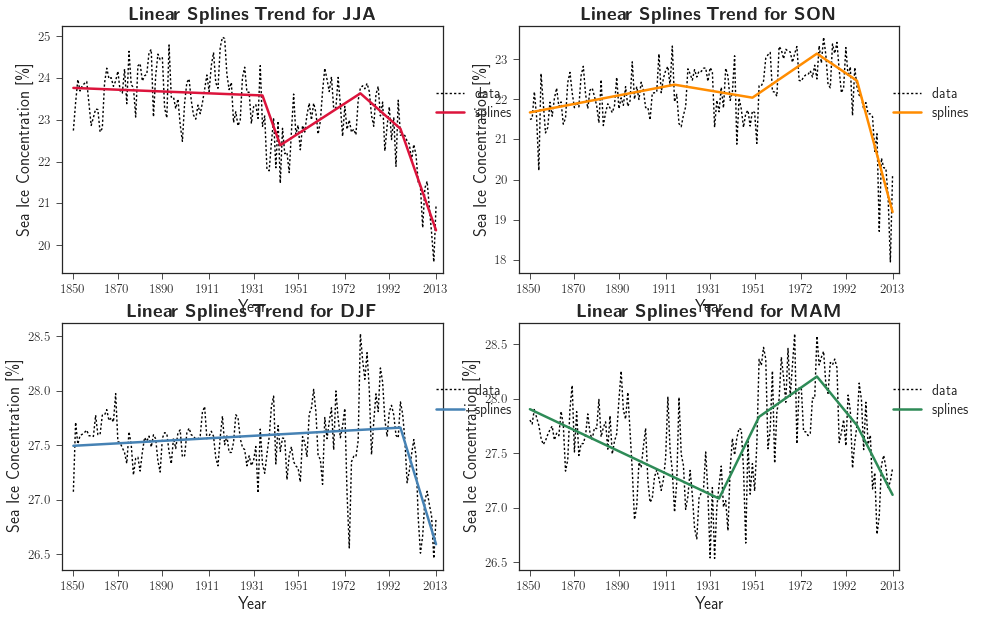

In [23]:
f, axs = plt.subplots(2, 2, figsize=(15,10))
axs = np.array(axs)

for i, ax in enumerate(axs.reshape(-1)):
    s = seasons[i]
    yr = dfs[s].year
    conc = dfs[s].seaice_conc
    preds = splines2[s].fittedvalues
    plot_splines(yr, conc, preds, 'splines', season=s, ax=ax, col=cmap[s])

In [24]:
# Estimates Pt.2
mu_hat2 = {season: spl.mu for season, spl in splines2.items()}
R2 = {season: spl.resid_response.values for season, spl in splines2.items()}
cov2 = {season: spl.cov_params() for season, spl in splines2.items()}
pvals2 = {season: spl.pvalues.values for season, spl in splines2.items()}

bonferonnis2 = {season: (smm.multipletests(pval, method='bonferroni')[:2])
               for season, pval in pvals2.items()}

for season, test in bonferonnis2.items():
    print('{}: {}'.format(season, test[0]))

JJA: [ True False  True  True  True  True]
SON: [ True  True  True  True  True  True]
DJF: [ True  True  True]
MAM: [ True  True  True False  True False]


Once again, we see some splines that don't make the cut. We'll remove those, and recompute our model. Our knots are now:

$$
K_{\text{JJA}} = \{1996\}\\
K_{\text{SON}} = \{1996\}\\
K_{\text{DJF}} = \{1996\}\\
K_{\text{MAM}} = \{1933, 1979\}
$$


In [25]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

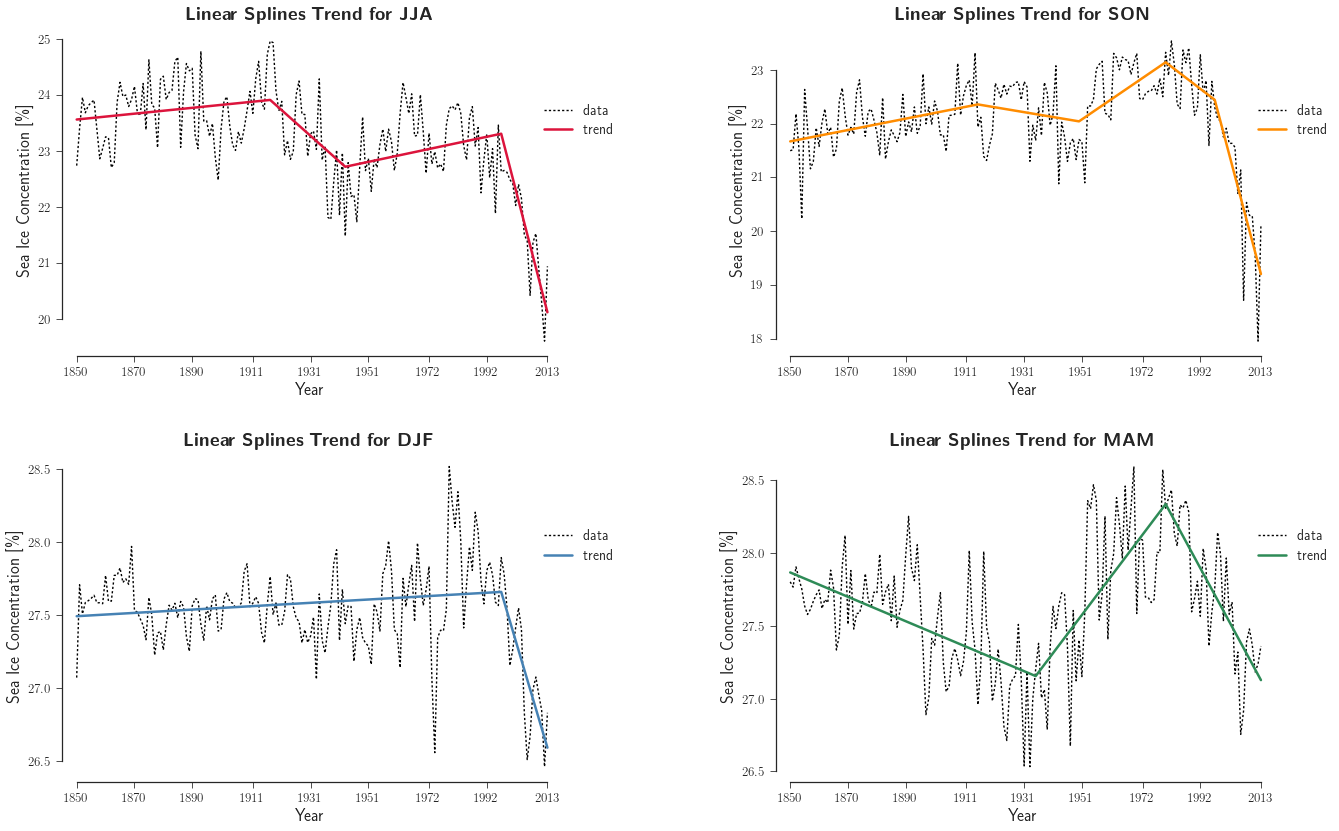

In [30]:
# Estimates Pt.3
#jjaknots3 = [1997]
#sonknots3 = [1997]
#djfknots3 = [1997]
#mamknots3 = [1933, 1979]

jjaknots3 = [1917, 1943,1997]
sonknots3 = [1915, 1950, 1980, 1997]
djfknots3 = [1997]
mamknots3 = [1935, 1980]


splines3 = {'DJF': linear_splines(djf_df, djfknots3),
           'MAM': linear_splines(mam_df, mamknots3),
           'JJA': linear_splines(jja_df, jjaknots3),
           'SON': linear_splines(son_df, sonknots3)}

f, axs = plt.subplots(2, 2, figsize=(20,12))
sns.set_style("ticks")

axs = np.array(axs)

for i, ax in enumerate(axs.reshape(-1)):
    s = seasons[i]
    yr = dfs[s].year
    conc = dfs[s].seaice_conc
    preds = splines3[s].fittedvalues
    plot_splines(yr, conc, preds, 'trend', season=s, ax=ax, col=cmap[s])
    
f.subplots_adjust(wspace=20, hspace=5)
f.tight_layout()
sns.despine(trim=True)

f.savefig('/home/hflores/repos/ArcticSea/writeup/figs/trends.eps', format='eps', 
          dpi=1200, bbox_inches='tight')

In [29]:
# Bonferonnis Pt.3
mu_hat3 = {season: spl.mu for season, spl in splines3.items()}
R3 = {season: spl.resid_response.values for season, spl in splines3.items()}
cov3 = {season: spl.cov_params() for season, spl in splines3.items()}
pvals3 = {season: spl.pvalues.values for season, spl in splines3.items()}

bonferonnis3 = {season: (smm.multipletests(pval, method='fdr_tsbh')[:2])
               for season, pval in pvals3.items()}

for season, test in bonferonnis3.items():
    print('{}: {}'.format(season, test[0]))

DJF: [ True  True  True]
MAM: [ True  True  True  True]
JJA: [ True  True  True  True  True]
SON: [ True  True  True  True  True  True]


Finally! We have a set of knots that are significant.

# Test our detrended series for stationarity

1. Plot our detrended series
2. Perform the Augmented Dickey-Fuller test 
    * Check p-values (if p-value is < 0.05, hence the data is staionary)

In [124]:
# Rename R3 to something more meaningful: residuals
residuals = R3

### 1. Plot detrended series

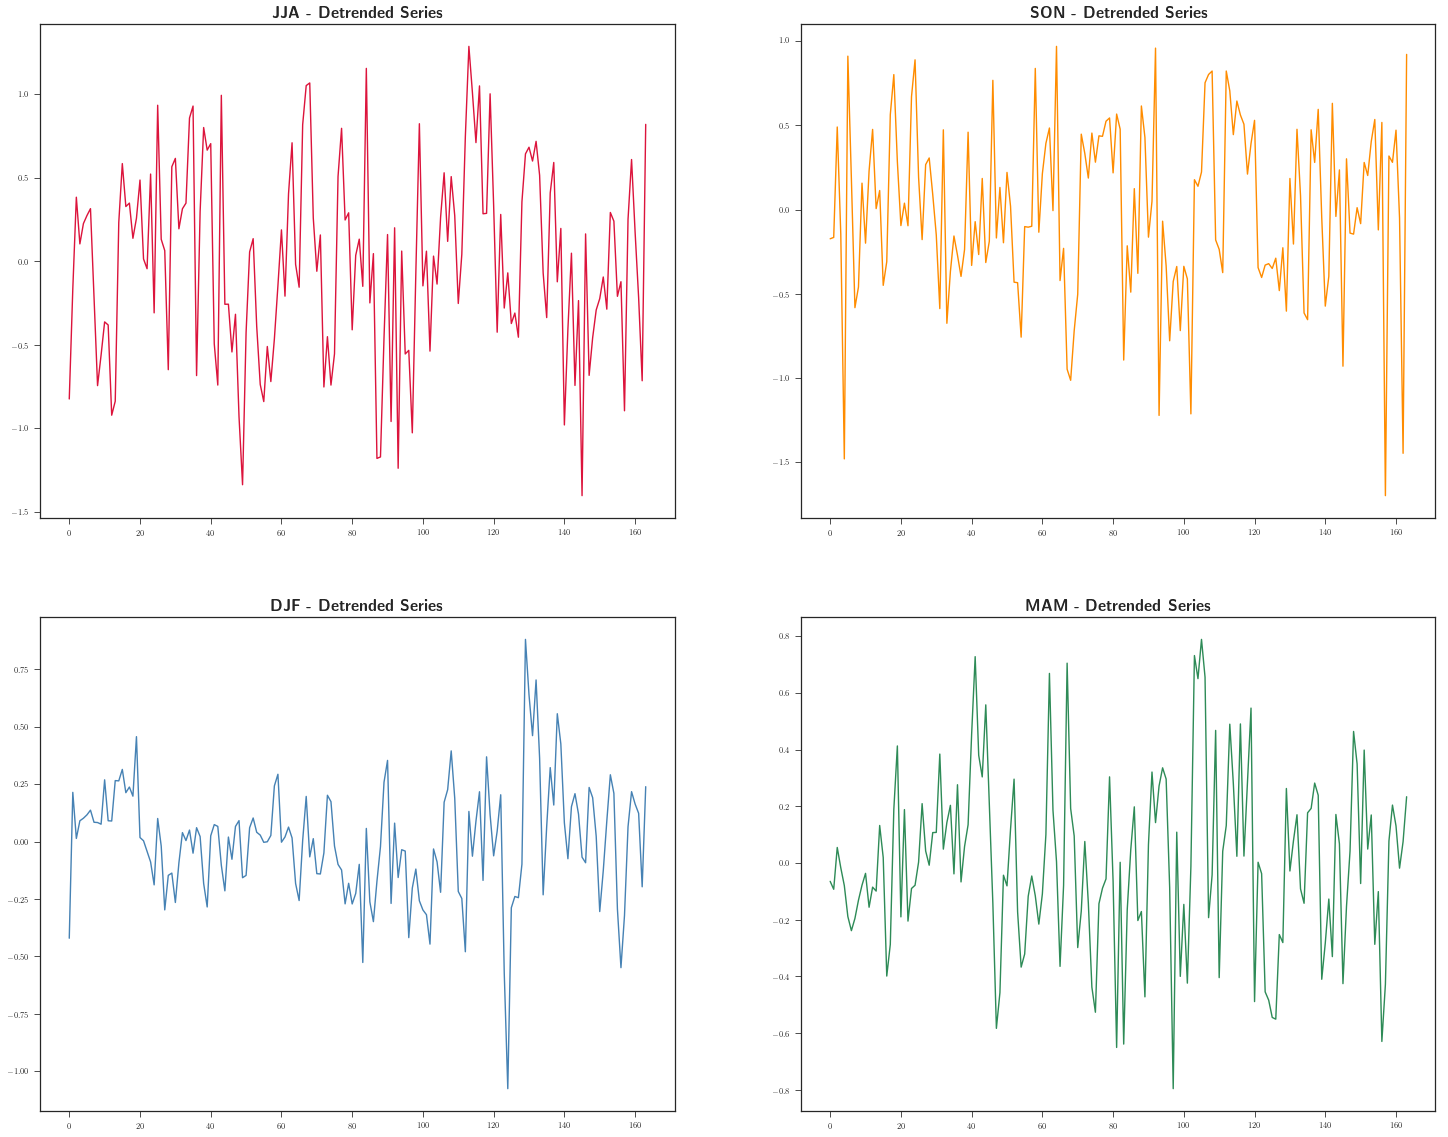

In [125]:
f, axs = plt.subplots(2, 2, figsize=(25,20))

axs[0,0].plot(residuals['JJA'], color=cmap['JJA'])
axs[0,0].set_title(r'\textbf{JJA - Detrended Series}', fontsize=16)


axs[0,1].plot(residuals['SON'], color=cmap['SON'])
axs[0,1].set_title(r'\textbf{SON - Detrended Series}', fontsize=16)


axs[1,0].plot(residuals['DJF'], color=cmap['DJF'])
axs[1,0].set_title(r'\textbf{DJF - Detrended Series}', fontsize=16)

axs[1,1].plot(residuals['MAM'], color=cmap['MAM'])
axs[1,1].set_title(r'\textbf{MAM - Detrended Series}', fontsize=16)


### 2. Augmented Dickey-Fuller test for stationarity

In [128]:
def test_stationarity(timeseries, label='Original', ax=None):
    if ax is None:
        ax = plt.gca()
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=15)
    rolstd = pd.rolling_std(timeseries, window=15)

    #Plot rolling statistics:
    orig = ax.plot(timeseries, color='k', alpha=0.3, label=label)
    mean = ax.plot(rolmean, color='darkred', label='Rolling Mean')
    std = ax.plot(rolstd, color='darkorange', label = 'Rolling Std')
    ax.legend(loc='best')
    ax.set_title('Rolling Mean & Standard Deviation')
    #ax.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = tsa.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

/home/hflores/anaconda2/envs/arcticsea/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/home/hflores/anaconda2/envs/arcticsea/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version


Results of Dickey-Fuller Test:
Test Statistic                -7.505197e+00
p-value                        4.152381e-11
#Lags Used                     1.000000e+00
Number of Observations Used    1.620000e+02
Critical Value (1%)           -3.471374e+00
Critical Value (5%)           -2.879552e+00
Critical Value (10%)          -2.576373e+00
dtype: float64


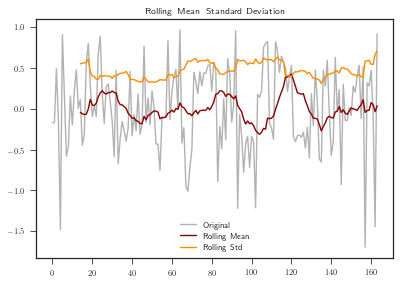

In [129]:
test_stationarity(residuals['SON'])

In [130]:
# MacKinnon’s approximate p-value based on MacKinnon (1994, 2010)
ad_pvalues = {season: tsa.adfuller(resid)[1] for season, resid in residuals.items()}

In [131]:
ad_pvalues

{'DJF': 4.3302468038508157e-11,
 'JJA': 5.1696274729937322e-08,
 'MAM': 3.862993127552056e-13,
 'SON': 4.152380769832061e-11}

All p-values are < 0.05, hence the detrended series are staionary.

# Determine the type of model

We want to determine whether our model is AR(p), MA(q), ARIMA, etc...

1. Plot ACF and PACF of our detrended series
2. Look at the estimated power spectral density (smoothed periodogram) for periodicity
3. From the periodograms determine the frequency for our model.

### 1. Plot ACFs and PACFs of the residiuals (detrended series) for each season

In [132]:
def plot_corr(acf_x, nlags, col, ax=None, title='Autocorrelation', **kwargs):
    def bonferroni_confint(x, alpha=0.05):
        nobs = len(x)
        confint = sp.stats.norm.ppf(1 - alpha/nobs) / np.sqrt(nobs)
        return confint, -confint
    
    confint = bonferroni_confint(acf_x)
    
    if ax is None:
        ax = plt.gca()
        
    fig = ax.stem(acf_x, color=col)
    plt.setp(fig[1], color=col)
    plt.setp(fig[0], 'markersize', 0)
    ax.set_title(r"\textbf{" + title + "}", fontsize=19)
    ax.set_ylim([min(acf_x)-0.3, 1])
    ax.set_xlabel(r"Lag", fontsize=17)
    
    if "pacf" in title.lower() or "partial" in title.lower():
        ax.set_ylabel(r"Partial ACF", fontsize=17)
    else:
        ax.set_ylabel(r"ACF", fontsize=17)

    if confint is not None:
        ax.axhline(y=confint[0],xmin=0,xmax=nlags,c='black',linewidth=0.5,linestyle='--',zorder=0)
        ax.axhline(y=confint[1],xmin=0,xmax=nlags,c='black',linewidth=0.5,linestyle='--',zorder=0)
    return fig

In [133]:
def plot_acf(data, nlags, col, alpha=0.05, ax=None, title='Autocorrelation'):
    acf_x, _ = tsa.acf(data, nlags=nlags, alpha=alpha)
    return plot_corr(acf_x, nlags=nlags, col=col, ax=ax, title=title)

In [134]:
def plot_pacf(data, nlags, col, alpha=0.05, ax=None, title='Partial Autocorrelation'):
    method = 'ywm'
    pacf_x, _ = tsa.pacf(data, nlags=nlags, alpha=alpha, method=method)
    return plot_corr(pacf_x, nlags=nlags, col=col, ax=ax, title=title)

In [135]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [136]:
cmap['DJF']

'steelblue'

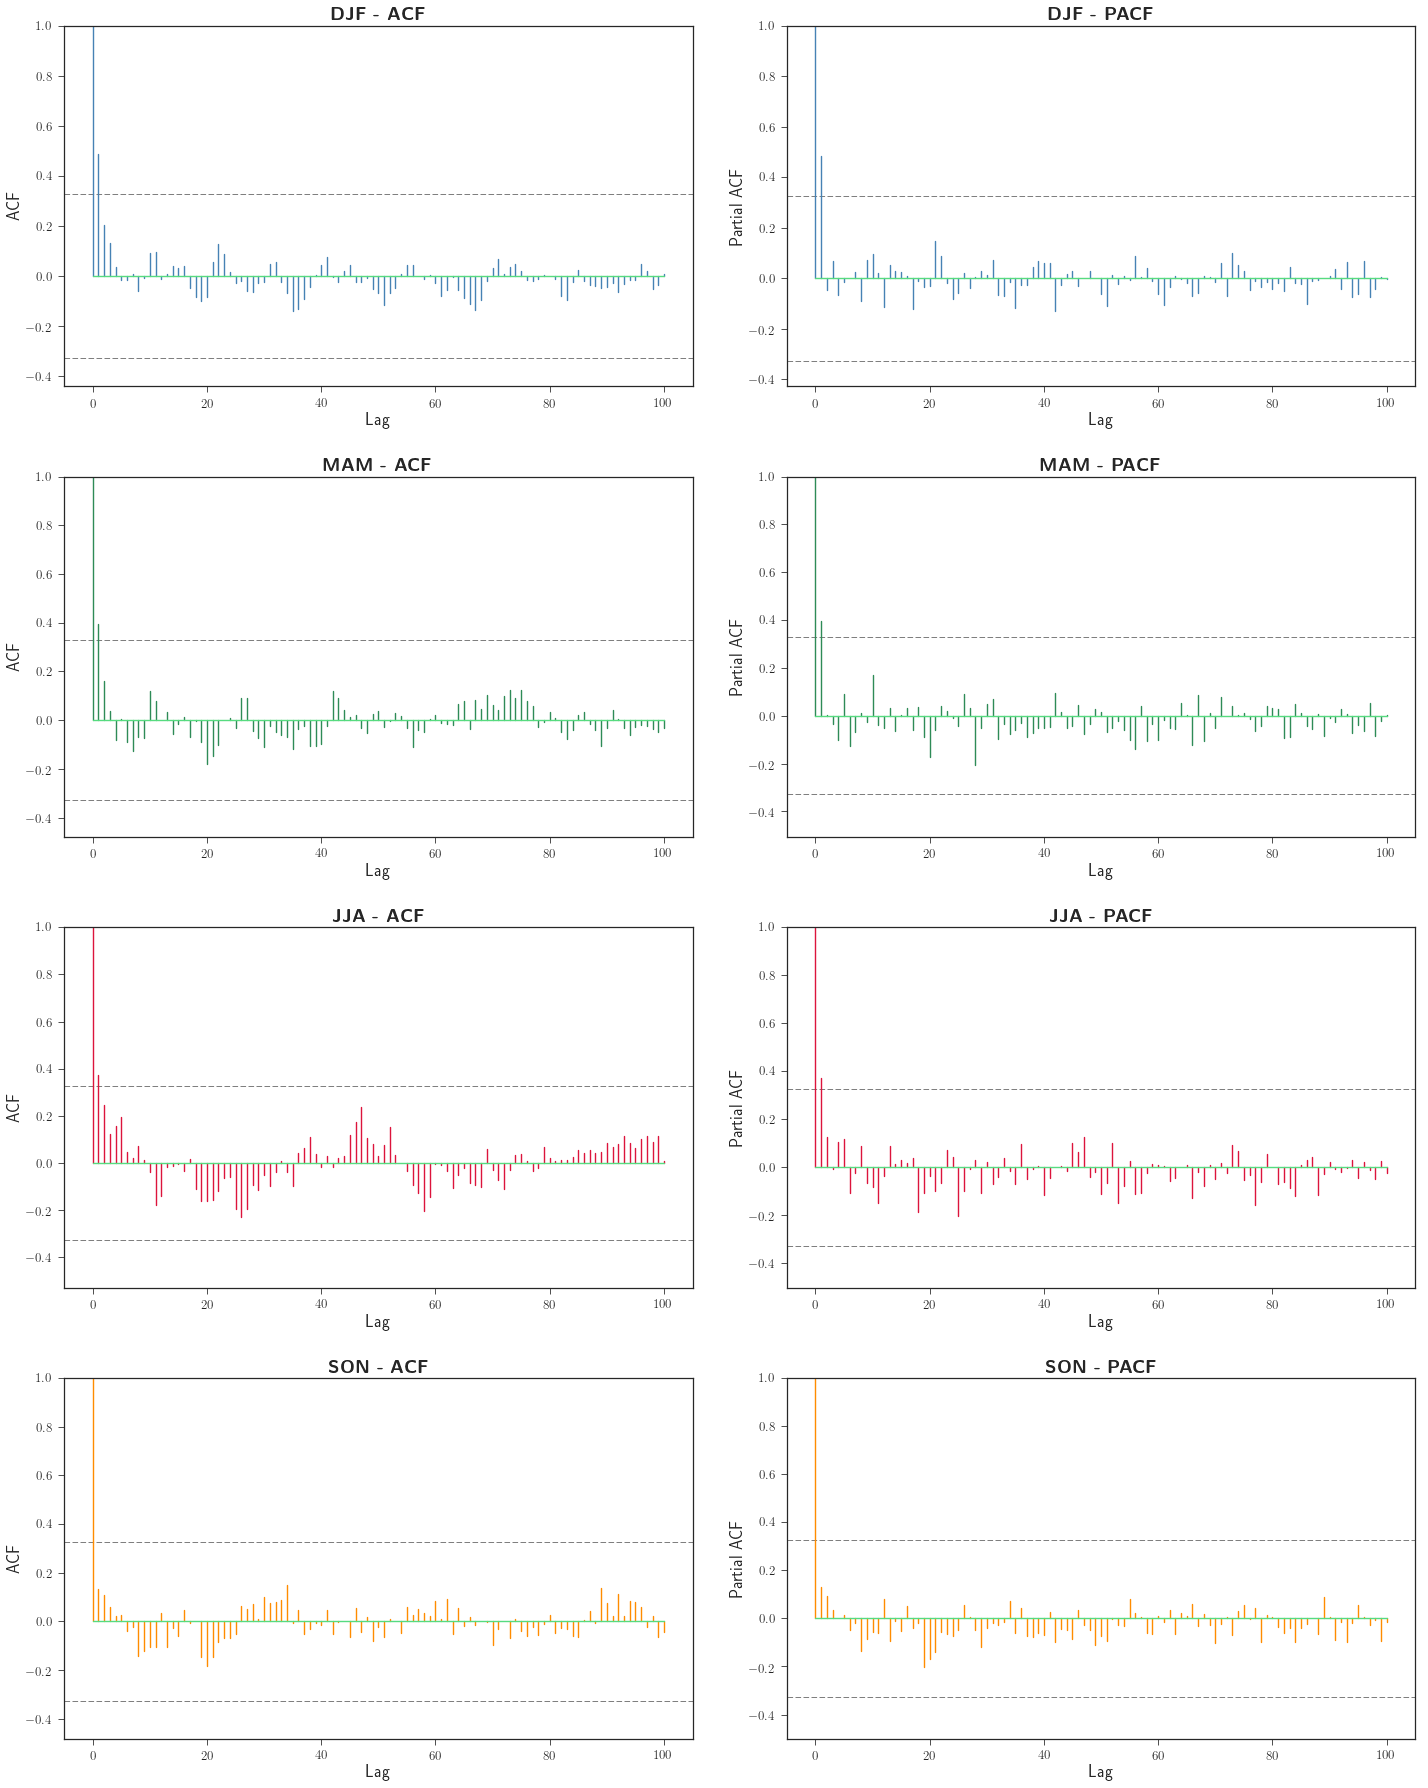

In [137]:
# Plot ACFs and PACFs
f, axs = plt.subplots(4, 2, figsize=(20,25))

plot_acf(residuals['DJF'], nlags=100, ax=axs[0,0], title='DJF - ACF', col=cmap['DJF'])
axs[0,0].xaxis.set_tick_params(labelsize=13)
axs[0,0].yaxis.set_tick_params(labelsize=13)

plot_pacf(residuals['DJF'], nlags=100, ax=axs[0,1], title='DJF - PACF', col=cmap['DJF'])
axs[0,1].xaxis.set_tick_params(labelsize=13)
axs[0,1].yaxis.set_tick_params(labelsize=13)


plot_acf(residuals['MAM'], nlags=100, ax=axs[1,0], title='MAM - ACF', col=cmap['MAM'])
axs[1,0].xaxis.set_tick_params(labelsize=13)
axs[1,0].yaxis.set_tick_params(labelsize=13)

plot_pacf(residuals['MAM'], nlags=100, ax=axs[1,1], title='MAM - PACF', col=cmap['MAM'])
axs[1,1].xaxis.set_tick_params(labelsize=13)
axs[1,1].yaxis.set_tick_params(labelsize=13)

plot_acf(residuals['JJA'], nlags=100, ax=axs[2,0], title='JJA - ACF', col=cmap['JJA'])
axs[2,0].xaxis.set_tick_params(labelsize=13)
axs[2,0].yaxis.set_tick_params(labelsize=13)

plot_pacf(residuals['JJA'], nlags=100, ax=axs[2,1], title='JJA - PACF', col=cmap['JJA'])
axs[2,1].xaxis.set_tick_params(labelsize=13)
axs[2,1].yaxis.set_tick_params(labelsize=13)

plot_acf(residuals['SON'], nlags=100, ax=axs[3,0], title='SON - ACF', col=cmap['SON'])
axs[3,0].xaxis.set_tick_params(labelsize=13)
axs[3,0].yaxis.set_tick_params(labelsize=13)

plot_pacf(residuals['SON'], nlags=100, ax=axs[3,1], title='SON - PACF', col=cmap['SON'])
axs[3,1].xaxis.set_tick_params(labelsize=13)
axs[3,1].yaxis.set_tick_params(labelsize=13)

#sns.despine(trim=True)
f.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.25)

#f.savefig('/home/hflores/repos/ArcticSea/writeup/figs/acfs.eps', format='eps', 
#          dpi=1200, bbox_inches='tight')

In [138]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [139]:
# f, axr = plt.subplots(4, 2, figsize=(18,16))

# axr[0,0].scatter(jja_df.year, residuals['JJA'], color=cmap['JJA'])
# axr[0,0].set_ylabel('Residual')
# axr[0,0].set_title('JJA')
# axr[0,1].scatter(jja_df.seaice_conc, residuals['JJA'], color=cmap['JJA'])

# axr[1,0].scatter(son_df.year, residuals['SON'], color=cmap['SON'])
# axr[1,0].set_ylabel('Residual')
# axr[1,0].set_title('SON')
# axr[1,1].scatter(son_df.seaice_conc, residuals['SON'], color=cmap['SON'])

# axr[2,0].scatter(djf_df.year, residuals['DJF'], color=cmap['DJF'])
# axr[2,0].set_ylabel('Residual')
# axr[2,0].set_title('DJF')
# axr[2,1].scatter(djf_df.seaice_conc, residuals['DJF'], color=cmap['DJF'])

# axr[3,0].scatter(mam_df.year, residuals['MAM'], color=cmap['MAM'])
# axr[3,0].set_ylabel('Residual')
# axr[3,0].set_title('MAM')
# axr[3,1].scatter(mam_df.seaice_conc, residuals['MAM'], color=cmap['MAM'])

# axr[3,0].set_xlabel('Years')
# axr[3,1].set_xlabel('Seaice Concentration')

### 2. Spectral Density Estimation via Welch's method

In [140]:
# Compute FFT of the residuals
# Take the periodogram (abs(R)^2)
# Plot the periodogram

In [141]:
#ffts = {season: np.fft.fft(resid) for season, resid in residuals.items()}
#periodograms = {season: np.abs(fftr)**2 for season, fftr in ffts.items()}
periodograms = {season: signal.welch(resid, window='hann')[1] for season, resid in residuals.items()}

/home/hflores/anaconda2/envs/arcticsea/lib/python3.6/site-packages/scipy/signal/spectral.py:772: UserWarning: nperseg = 256, is greater than input length = 164, using nperseg = 164
  'using nperseg = {1:d}'.format(nperseg, x.shape[-1]))


In [142]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

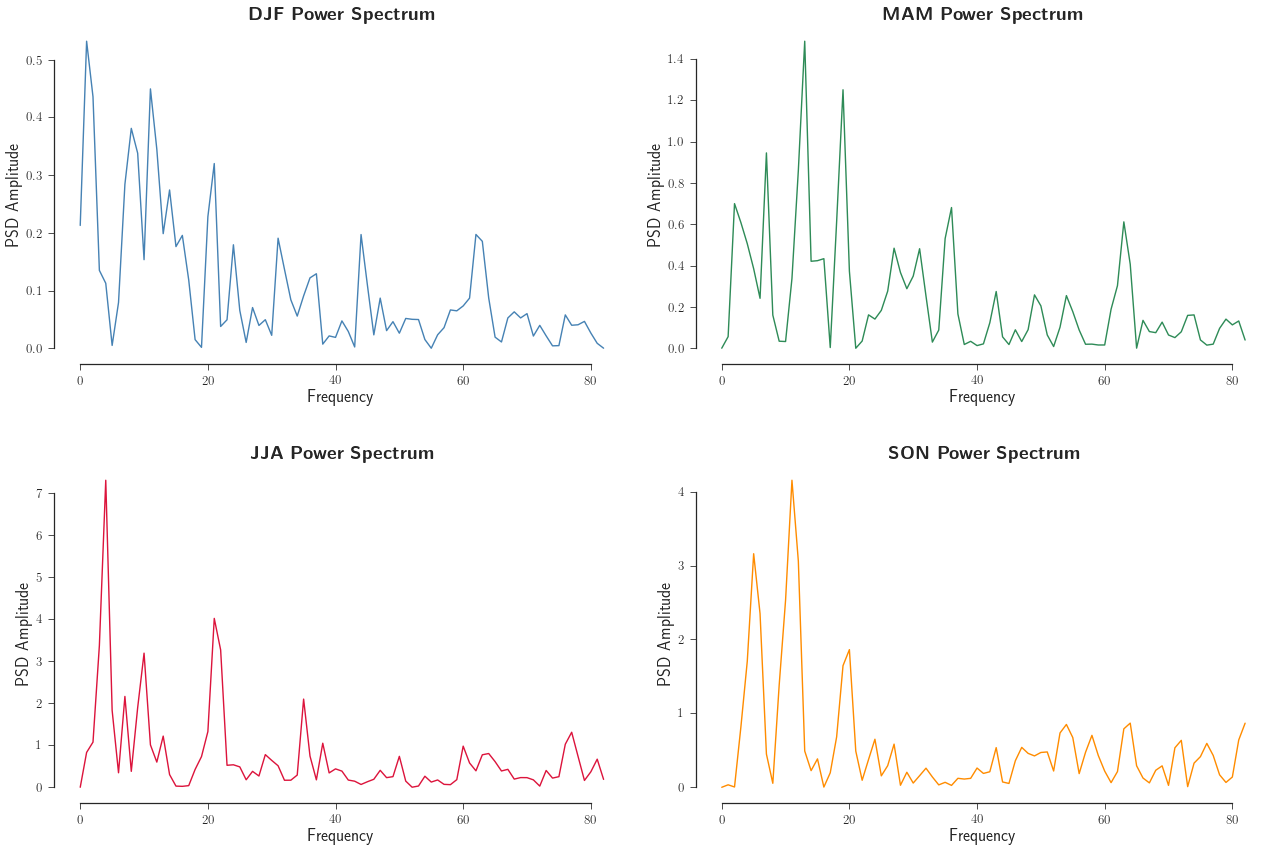

In [147]:
f, ax = plt.subplots(2, 2, figsize=(18,12))

ax[0,0].plot(periodograms['DJF'], color=cmap['DJF'])
ax[0,0].set_title(r'\textbf{DJF Power Spectrum}', fontsize=19)
ax[0,0].set_xlabel(r'Frequency', fontsize=17)
ax[0,0].set_ylabel(r'PSD Amplitude', fontsize=17)
ax[0,0].xaxis.set_tick_params(labelsize=13)
ax[0,0].yaxis.set_tick_params(labelsize=13)

ax[0,1].plot(periodograms['MAM'], color=cmap['MAM'])
ax[0,1].set_title(r'\textbf{MAM Power Spectrum}', fontsize=19)
ax[0,1].set_xlabel(r'Frequency', fontsize=17)
ax[0,1].set_ylabel(r'PSD Amplitude', fontsize=17)
ax[0,1].xaxis.set_tick_params(labelsize=13)
ax[0,1].yaxis.set_tick_params(labelsize=13)

ax[1,0].plot(periodograms['JJA'], color=cmap['JJA'])
ax[1,0].set_title(r'\textbf{JJA Power Spectrum}', fontsize=19)
ax[1,0].set_xlabel(r'Frequency', fontsize=17)
ax[1,0].set_ylabel(r'PSD Amplitude', fontsize=17)
ax[1,0].xaxis.set_tick_params(labelsize=13)
ax[1,0].yaxis.set_tick_params(labelsize=13)

ax[1,1].plot(periodograms['SON'], color=cmap['SON'])
ax[1,1].set_title(r'\textbf{SON Power Spectrum}', fontsize=19)
ax[1,1].set_xlabel(r'Frequency', fontsize=17)
ax[1,1].set_ylabel(r'PSD Amplitude', fontsize=17)
ax[1,1].xaxis.set_tick_params(labelsize=13)
ax[1,1].yaxis.set_tick_params(labelsize=13)

sns.despine(trim=True)
f.tight_layout()
plt.subplots_adjust(hspace=0.3)

f.savefig('/home/hflores/repos/ArcticSea/writeup/figs/psd.eps', format='eps', 
          dpi=1200, bbox_inches='tight')

### 3. Get peaks to determine the frequency

In [155]:
freqs = {season: np.argmax(psd) for season, psd in periodograms.items()}
freqs

{'DJF': 1, 'JJA': 4, 'MAM': 13, 'SON': 11}

In [156]:
t1 = yr_avg.year.values
nyrs = t1.max() - t1.min() + 1

# JJA

In [157]:
y_jja = jja_df.seaice_conc.values
sin4_jja = np.array([np.sin(2*np.pi* 4 * (t/nyrs)) for t in np.arange(nyrs)])
cos4_jja = np.array([np.cos(2*np.pi* 4 * (t/nyrs)) for t in np.arange(nyrs)])

sin21_jja = np.array([np.sin(2*np.pi* 21 * (t/nyrs)) for t in np.arange(nyrs)])
cos21_jja = np.array([np.cos(2*np.pi* 21 * (t/nyrs)) for t in np.arange(nyrs)])

sin3_jja = np.array([np.sin(2*np.pi* 3 * (t/nyrs)) for t in np.arange(nyrs)])
cos3_jja = np.array([np.cos(2*np.pi* 3 * (t/nyrs)) for t in np.arange(nyrs)])

sin22_jja = np.array([np.sin(2*np.pi* 22 * (t/nyrs)) for t in np.arange(nyrs)])
cos22_jja = np.array([np.cos(2*np.pi* 22 * (t/nyrs)) for t in np.arange(nyrs)])

sin10_jja = np.array([np.sin(2*np.pi* 10 * (t/nyrs)) for t in np.arange(nyrs)])
cos10_jja = np.array([np.cos(2*np.pi* 10 * (t/nyrs)) for t in np.arange(nyrs)])

In [158]:
fit_jja = smf.glm(
    'y_jja ~ sin4_jja + cos4_jja + \
    sin21_jja + cos21_jja + \
    sin3_jja + cos3_jja + \
    sin22_jja + cos22_jja +\
    sin10_jja + cos10_jja',data=jja_df).fit()
fit_jja.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  y_jja   No. Observations:                  164
Model:                            GLM   Df Residuals:                      153
Model Family:                Gaussian   Df Model:                           10
Link Function:               identity   Scale:                  0.622918078195
Method:                          IRLS   Log-Likelihood:                -188.20
Date:                Wed, 26 Jul 2017   Deviance:                       95.306
Time:                        16:13:39   Pearson chi2:                     95.3
No. Iterations:                     2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.2248      0.062    376.841      0.000      23.104      23.346
sin4_jja      -0.0680      0.087     -0.780      0.435      -0.239       0.103
cos4_jja      -0.1498      0.087     -1.719      0.086      -0.321       0.021
sin21_jja     -0.1102      0.087     -1.264      0.206      -0.281       0.061
cos21_jja     -0.0379      0.087     -0.435      0.663      -0.209       0.133
sin3_jja       0.4793      0.087      5.499      0.000       0.308       0.650
cos3_jja      -0.2512      0.087     -2.882      0.004      -0.422      -0.080
sin22_jja      0.2102      0.087      2.411      0.016       0.039       0.381
cos22_jja      0.0074      0.087      0.085      0.932      -0.163       0.178
sin10_jja      0.2097      0.087      2.406      0.016       0.039       0.381
cos10_jja      0.2092      0.087      2.400      0.016       0.038       0.380
==============================================================================
"""

**NOTE: sine and cosine are significant**

In [159]:
print(fit_jja.params)
k_hat_jja = fit_jja.params.values  # extract fitted regression coefficients
e_jja = fit_jja.resid_response    # extract raw residuals

Intercept    23.224777
sin4_jja     -0.067969
cos4_jja     -0.149823
sin21_jja    -0.110174
cos21_jja    -0.037950
sin3_jja      0.479261
cos3_jja     -0.251151
sin22_jja     0.210180
cos22_jja     0.007433
sin10_jja     0.209685
cos10_jja     0.209178
dtype: float64


In [160]:
# Check to see if the mean of residuals are numerically close to 0
print(np.mean(e_jja))

4.484217875071364e-15


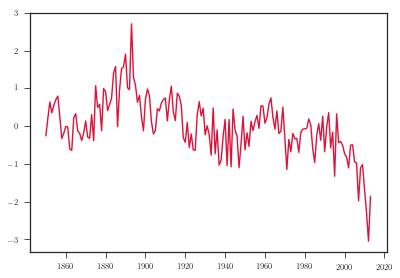

In [161]:
plt.plot(jja_df.year, e_jja, color=cmap['JJA'])

### Fit seasonal cycle with significant terms (sine and cosine)

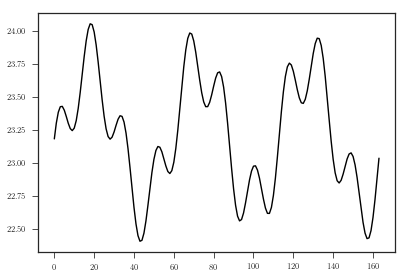

In [162]:
# fitted seasonal cycle
f_hat_jja = k_hat_jja[0] + k_hat_jja[5]*sin3_jja + k_hat_jja[6]*cos3_jja +\
            k_hat_jja[9]*sin10_jja+ k_hat_jja[10]*cos10_jja
plt.plot(f_hat_jja,'k-') 

In [163]:
# Remove residuals and subtract mean for second order residuals: R^2
resid2_jja = residuals['JJA'] - f_hat_jja
resid2_jja = resid2_jja - np.mean(resid2_jja)

<Container object of 3 artists>

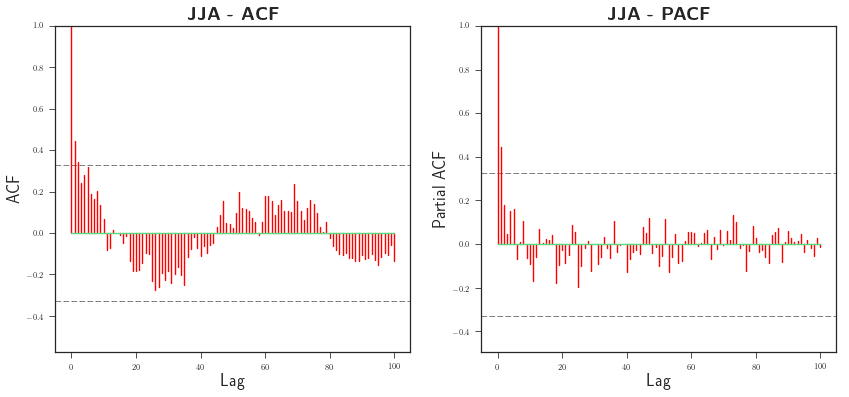

In [165]:
f, axs = plt.subplots(1, 2, figsize=(14,6))

plot_acf(resid2_jja, nlags=100, ax=axs[0], title='JJA - ACF', col='r')
plot_pacf(resid2_jja, nlags=100, ax=axs[1], title='JJA - PACF', col='r')

#f.savefig('/home/hflores/repos/kaust_presentation/jja_acf.eps', format='eps', 
#          dpi=1200, bbox_inches='tight')

In [166]:
# Fit AR1 & AR2 model
fit_jja_ar1 = arima.ARIMA(resid2_jja, (1,0,0)).fit()
fit_jja_ar2 = arima.ARIMA(resid2_jja, (2,0,0)).fit()
fit_jja_ar3 = arima.ARIMA(resid2_jja, (3,0,0)).fit()
fit_jja_arma21 = arima.ARIMA(resid2_jja, (2,0,1)).fit()
print(fit_jja_ar1.summary())
print(fit_jja_ar2.summary())
print(fit_jja_ar3.summary())
print(fit_jja_arma21.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  164
Model:                     ARMA(1, 0)   Log Likelihood                -130.819
Method:                       css-mle   S.D. of innovations              0.537
Date:                Wed, 26 Jul 2017   AIC                            267.637
Time:                        16:14:14   BIC                            276.937
Sample:                             0   HQIC                           271.413
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.076      0.015      0.988      -0.149       0.151
ar.L1.y        0.4537      0.070      6.448      0.000       0.316       0.592
                                    Roots           

**NOTE: Choose AR(2) since it has lower AIC and BIC**

In [177]:
def ts_diagnostics(fit, col, title='Season', save=None):
    # Removes fitted terms from residuals
    def ar_residuals(fit):
        e = fit.resid
        phi_hat = fit.arparams
        
        if ar == 1:
            return e[1:] - phi_hat*e[:-1]
            
        X1 = e[1:]
        X2 = e[:-1]
        
        # Make column vector
        X1 = X1[:,np.newaxis]
        X2 = X2[:,np.newaxis]
        
        X = np.hstack((X1, X2))
        e_ar = e[1:] - np.dot(X, phi_hat)
        return e_ar
    
    #e_ar = ar_residuals(fit)
    e_ar = fit.resid
    x = np.arange(len(e_ar))
    
    import matplotlib.gridspec as gridspec
    f = plt.figure(figsize=(14,14))
    sns.set_style("ticks")
    gs = gridspec.GridSpec(3, 2)
    ax1 = plt.subplot(gs[0,:])
    ax2 = plt.subplot(gs[1,0])
    ax3 = plt.subplot(gs[1,1])
    ax4 = plt.subplot(gs[2,0])
    ax5 = plt.subplot(gs[2,1])
    
    ax1.plot(list(range(1850, 2014)), e_ar, color=col)
    r"\textbf{" + title + "}"
    ax1.set_title(r'\textbf{' + title + ' Residuals}', fontsize=19)
    ax1.set_xticks(np.linspace(1850, 2013, 9, dtype=int))
    ax1.set_xlabel(r'Year', fontsize=17)
    ax1.xaxis.set_tick_params(labelsize=13)
    ax1.yaxis.set_tick_params(labelsize=13)

    
    plot_acf(e_ar, nlags=len(e_ar)-1, col=col, title=title+" ACF", ax=ax2)
    ax2.xaxis.set_tick_params(labelsize=13)
    ax2.yaxis.set_tick_params(labelsize=13)
    
    plot_pacf(e_ar, nlags=len(e_ar)-1, col=col, title=title+" PACF", ax=ax3)
    ax3.xaxis.set_tick_params(labelsize=13)
    ax3.yaxis.set_tick_params(labelsize=13)
    
    lb = ljungbox(e_ar, 10)[1]
    ax4.scatter(list(range(1,11)), lb, color=col)
    ax4.set_ylim(min(lb)-0.05, max(lb)+0.05)
    yticks = np.linspace(min(lb), max(lb), 6)
    ax4.set_yticks(np.round(yticks, 3))
    ax4.set_title(r'\textbf{P-values for Ljung-Box statistic}', fontsize=19)
    ax4.set_xlabel(r'Lag', fontsize=17)
    ax4.xaxis.set_tick_params(labelsize=13)
    ax4.yaxis.set_tick_params(labelsize=13)
    
    stats.probplot(e_ar, dist="norm", plot=ax5)
    ax5.set_title(r'\textbf{QQ Plot of Residuals}', fontsize=19)
    ax5.set_xlabel(r'Theoretical quantiles', fontsize=17)
    ax5.set_ylabel(r'Ordered Values', fontsize=17)
    ax5.xaxis.set_tick_params(labelsize=13)
    ax5.yaxis.set_tick_params(labelsize=13)

    f.subplots_adjust(wspace=0.25, hspace=0.5)
    f.tight_layout()
    sns.despine()
    
    
    if save:
        fname = '../writeup/figs/{}.eps'.format(save)
        f.savefig(fname, format='eps', dpi=1200, bbox_inches='tight')
    return e_ar

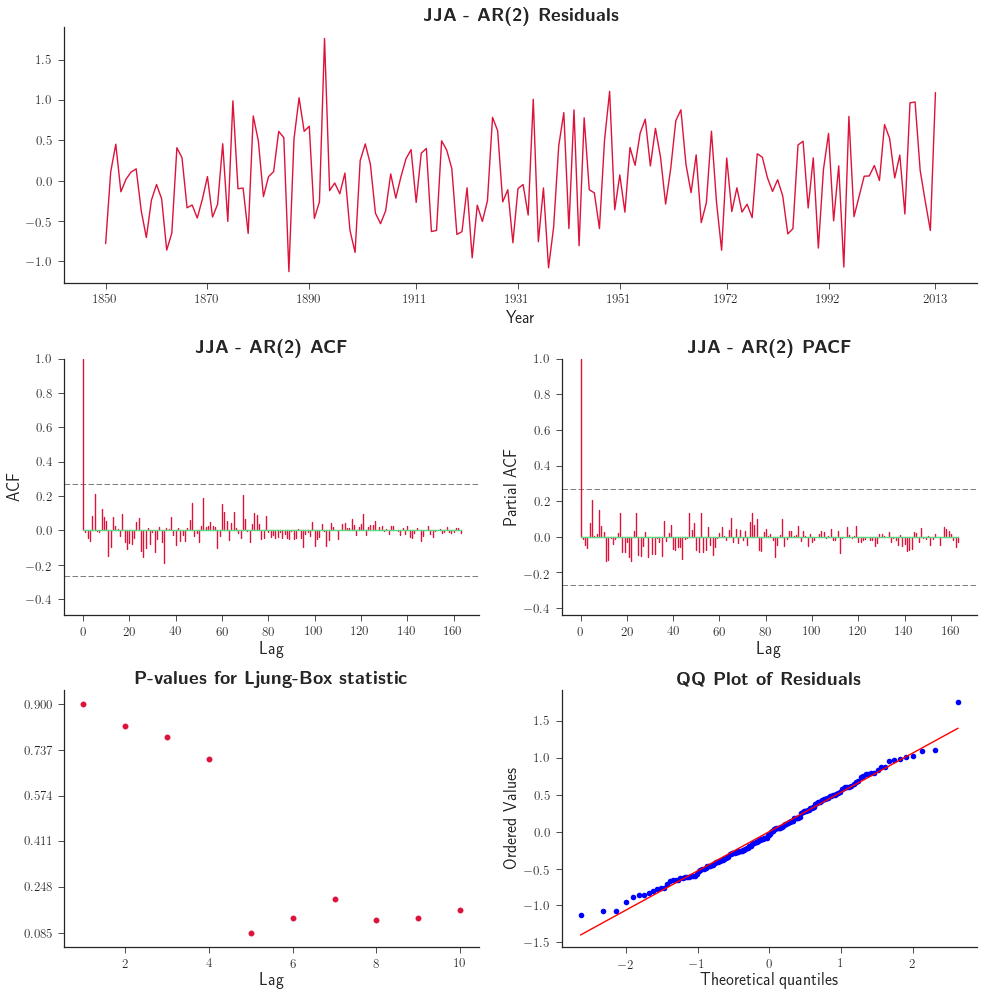

In [178]:
e_ar_jja = ts_diagnostics(fit_jja_ar2, col=cmap['JJA'], title="JJA - AR(2)", save='jja_res')

In [179]:
ks_results = scipy.stats.kstest(e_ar_jja, cdf='norm')
ks_results

KstestResult(statistic=0.17304068780901993, pvalue=9.1659398989474283e-05)

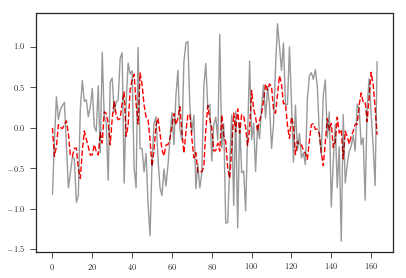

In [180]:
jja_predict = fit_jja_ar2.predict()

plt.plot(jja_predict, 'r--')
plt.plot(residuals['JJA'], color='k', alpha=0.4)

# SON

In [181]:
periodograms['SON'].argsort()[-5:][::-1]

array([11,  5, 12, 10,  6])

In [182]:
y_son = son_df.seaice_conc.values
sin11_son = np.array([np.sin(2*np.pi*11 * (t/nyrs)) for t in np.arange(nyrs)])
cos11_son = np.array([np.cos(2*np.pi*11 * (t/nyrs)) for t in np.arange(nyrs)])

sin5_son = np.array([np.sin(2*np.pi*5 * (t/nyrs)) for t in np.arange(nyrs)])
cos5_son = np.array([np.cos(2*np.pi*5 * (t/nyrs)) for t in np.arange(nyrs)])

sin12_son = np.array([np.sin(2*np.pi*12 * (t/nyrs)) for t in np.arange(nyrs)])
cos12_son = np.array([np.cos(2*np.pi*12 * (t/nyrs)) for t in np.arange(nyrs)])

sin10_son = np.array([np.sin(2*np.pi*10 * (t/nyrs)) for t in np.arange(nyrs)])
cos10_son = np.array([np.cos(2*np.pi*10 * (t/nyrs)) for t in np.arange(nyrs)])

sin6_son = np.array([np.sin(2*np.pi*6 * (t/nyrs)) for t in np.arange(nyrs)])
cos6_son = np.array([np.cos(2*np.pi*6 * (t/nyrs)) for t in np.arange(nyrs)])


In [183]:
fit_son = smf.glm(
    'y_son ~ sin11_son + cos11_son + \
             sin5_son + cos5_son + \
             sin12_son + cos12_son + \
             sin10_son + cos10_son + \
             sin6_son + cos6_son', data=son_df).fit()
fit_son.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  y_son   No. Observations:                  164
Model:                            GLM   Df Residuals:                      153
Model Family:                Gaussian   Df Model:                           10
Link Function:               identity   Scale:                  0.615512814419
Method:                          IRLS   Log-Likelihood:                -187.22
Date:                Wed, 26 Jul 2017   Deviance:                       94.173
Time:                        16:19:56   Pearson chi2:                     94.2
No. Iterations:                     2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.1133      0.061    360.959      0.000      21.993      22.233
sin11_son      0.1286      0.087      1.485      0.138      -0.041       0.298
cos11_son      0.1610      0.087      1.858      0.063      -0.009       0.331
sin5_son       0.1772      0.087      2.046      0.041       0.007       0.347
cos5_son      -0.2735      0.087     -3.157      0.002      -0.443      -0.104
sin12_son      0.0057      0.087      0.066      0.947      -0.164       0.176
cos12_son     -0.1021      0.087     -1.178      0.239      -0.272       0.068
sin10_son      0.0157      0.087      0.181      0.856      -0.154       0.186
cos10_son     -0.0730      0.087     -0.843      0.399      -0.243       0.097
sin6_son       0.1576      0.087      1.819      0.069      -0.012       0.327
cos6_son       0.0598      0.087      0.690      0.490      -0.110       0.230
==============================================================================
"""

In [184]:
# Check pvalues for coefficients
fit_son.pvalues

Intercept    0.000000
sin11_son    0.137570
cos11_son    0.063099
sin5_son     0.040772
cos5_son     0.001593
sin12_son    0.947329
cos12_son    0.238701
sin10_son    0.856201
cos10_son    0.399364
sin6_son     0.068985
cos6_son     0.490380
dtype: float64

In [185]:
print(fit_son.params)
k_hat_son = fit_son.params.values  # extract fitted regression coefficients
e_son = fit_son.resid_response    # extract raw residuals

Intercept    22.113337
sin11_son     0.128650
cos11_son     0.161017
sin5_son      0.177249
cos5_son     -0.273532
sin12_son     0.005724
cos12_son    -0.102081
sin10_son     0.015700
cos10_son    -0.073015
sin6_son      0.157554
cos6_son      0.059755
dtype: float64


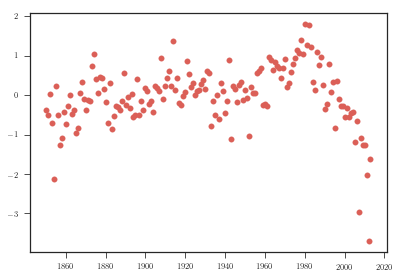

In [186]:
plt.scatter(son_df.year, e_son)

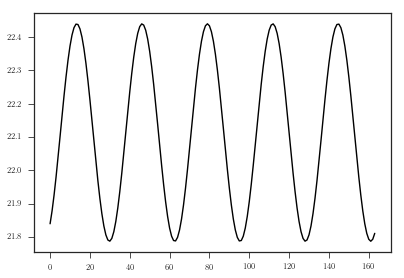

In [187]:
# fitted seasonal cycle
f_hat_son = k_hat_son[0] + k_hat_son[3]*sin5_son + k_hat_son[4]*cos5_son
plt.plot(f_hat_son,'k-')

In [188]:
# Remove residuals and subtract mean for second order residuals: R^2
resid2_son = residuals['SON'] - f_hat_son
resid2_son = resid2_son - np.mean(resid2_son)

<Container object of 3 artists>

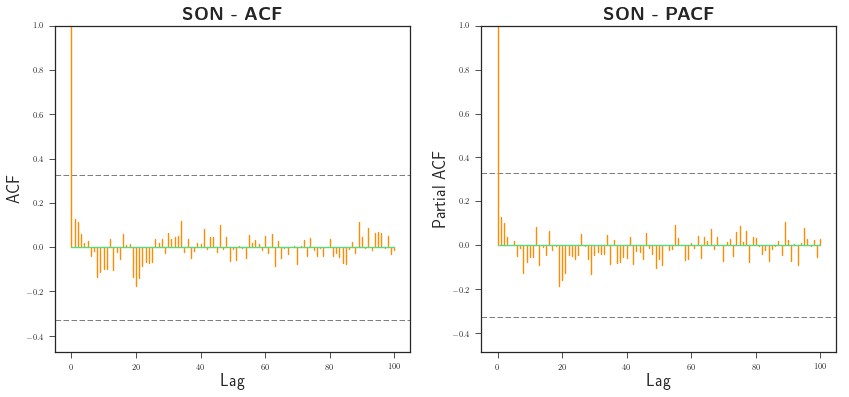

In [190]:
f, axs = plt.subplots(1, 2, figsize=(14,6))

plot_acf(resid2_son, nlags=100, col=cmap['SON'], ax=axs[0], title='SON - ACF')
plot_pacf(resid2_son, nlags=100, col=cmap['SON'], ax=axs[1], title='SON - PACF')

#f.savefig('/home/hflores/repos/kaust_presentation/son_acf.eps', format='eps', 
#          dpi=1200, bbox_inches='tight')

In [191]:
# Fit AR2 model for R^2
fit1_son = arima.ARIMA(resid2_son, (1,0,0)).fit()
fit2_son = arima.ARIMA(resid2_son, (2,0,0)).fit()
fit3_son = arima.ARIMA(resid2_son, (3,0,0)).fit()
fit4_son = arima.ARIMA(resid2_son, (2,0,1)).fit()

print(fit1_son.summary())
print(fit2_son.summary())
print(fit3_son.summary())
print(fit4_son.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  164
Model:                     ARMA(1, 0)   Log Likelihood                -121.583
Method:                       css-mle   S.D. of innovations              0.508
Date:                Wed, 26 Jul 2017   AIC                            249.165
Time:                        16:20:38   BIC                            258.465
Sample:                             0   HQIC                           252.941
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.046      0.027      0.979      -0.088       0.091
ar.L1.y        0.1323      0.079      1.683      0.094      -0.022       0.286
                                    Roots           

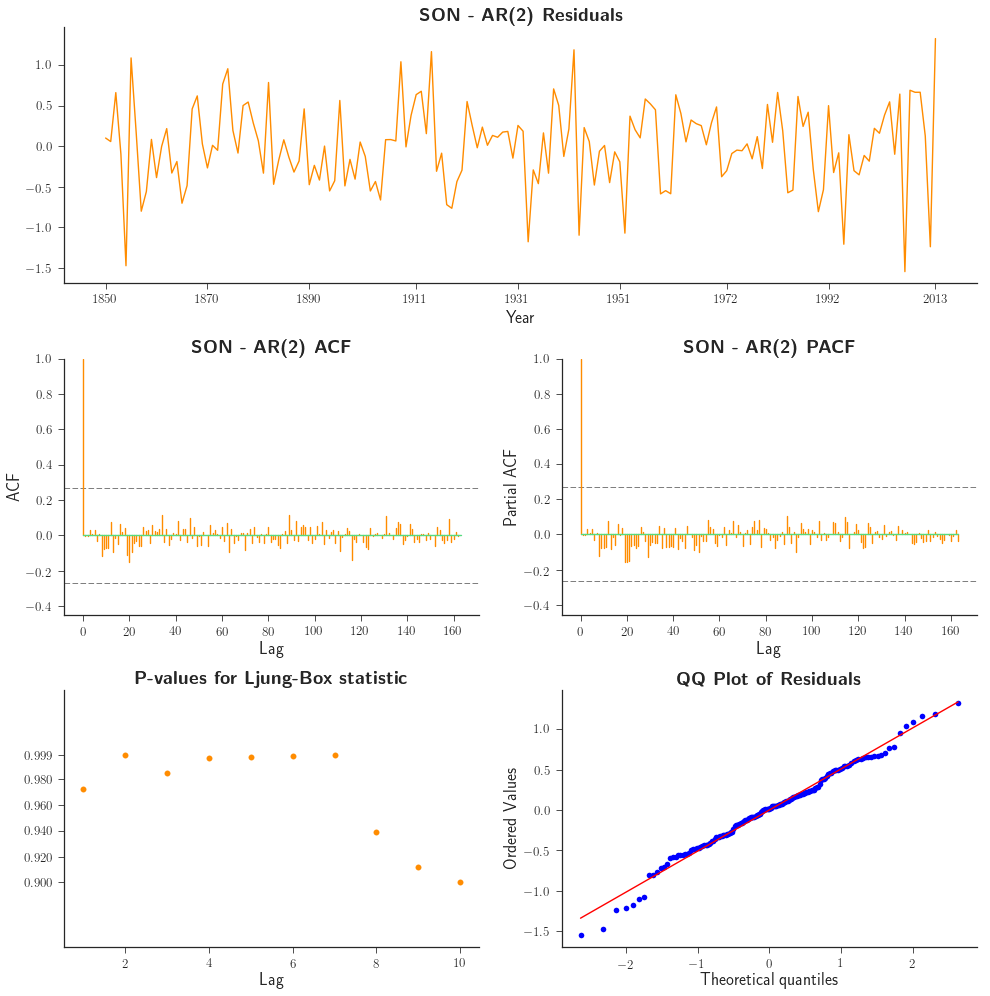

In [193]:
e_ar_son = ts_diagnostics(fit2_son, col=cmap['SON'], title='SON - AR(2)', save='son_res')

In [194]:
ks_son = scipy.stats.kstest(e_ar_son, cdf='norm')
ks_son

KstestResult(statistic=0.19835153144414003, pvalue=3.9467468098131064e-06)

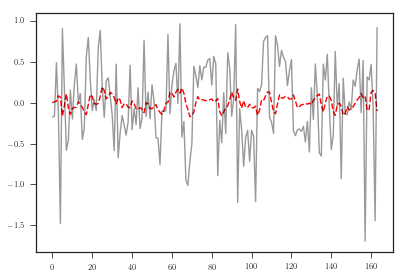

In [195]:
son_predict = fit2_son.predict()

plt.plot(son_predict, 'r--')
plt.plot(residuals['SON'], color='k', alpha=0.4)

# DJF

In [196]:
periodograms['DJF'].argsort()[-5:][::-1]

array([ 1, 11,  2,  8, 12])

In [197]:
y_djf = djf_df.seaice_conc.values
sin1_djf = np.array([np.sin(2*np.pi*1 * (t/nyrs)) for t in np.arange(nyrs)])
cos1_djf = np.array([np.cos(2*np.pi*1 * (t/nyrs)) for t in np.arange(nyrs)])

sin2_djf = np.array([np.sin(2*np.pi*2 * (t/nyrs)) for t in np.arange(nyrs)])
cos2_djf = np.array([np.cos(2*np.pi*2 * (t/nyrs)) for t in np.arange(nyrs)])

sin8_djf = np.array([np.sin(2*np.pi*8 * (t/nyrs)) for t in np.arange(nyrs)])
cos8_djf = np.array([np.cos(2*np.pi*8 * (t/nyrs)) for t in np.arange(nyrs)])

sin11_djf = np.array([np.sin(2*np.pi*11 * (t/nyrs)) for t in np.arange(nyrs)])
cos11_djf = np.array([np.cos(2*np.pi*11 * (t/nyrs)) for t in np.arange(nyrs)])

sin12_djf = np.array([np.sin(2*np.pi*12 * (t/nyrs)) for t in np.arange(nyrs)])
cos12_djf = np.array([np.cos(2*np.pi*12 * (t/nyrs)) for t in np.arange(nyrs)])

In [198]:
fit_djf = smf.glm(
    'y_djf ~ sin1_djf + cos1_djf +\
    sin2_djf + cos2_djf +\
    sin8_djf + cos8_djf +\
    sin11_djf + cos11_djf +\
    sin12_djf + cos12_djf', data=djf_df).fit()
fit_djf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  y_djf   No. Observations:                  164
Model:                            GLM   Df Residuals:                      153
Model Family:                Gaussian   Df Model:                           10
Link Function:               identity   Scale:                 0.0853023759789
Method:                          IRLS   Log-Likelihood:                -25.165
Date:                Wed, 26 Jul 2017   Deviance:                       13.051
Time:                        16:21:56   Pearson chi2:                     13.1
No. Iterations:                     2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.5290      0.023   1207.070      0.000      27.484      27.574
sin1_djf      -0.0436      0.032     -1.351      0.177      -0.107       0.020
cos1_djf      -0.0214      0.032     -0.663      0.507      -0.085       0.042
sin2_djf      -0.0250      0.032     -0.776      0.438      -0.088       0.038
cos2_djf      -0.1172      0.032     -3.633      0.000      -0.180      -0.054
sin8_djf       0.0303      0.032      0.941      0.347      -0.033       0.094
cos8_djf      -0.0581      0.032     -1.801      0.072      -0.121       0.005
sin11_djf      0.0066      0.032      0.206      0.837      -0.057       0.070
cos11_djf      0.0723      0.032      2.241      0.025       0.009       0.136
sin12_djf     -0.0106      0.032     -0.330      0.742      -0.074       0.053
cos12_djf     -0.0515      0.032     -1.596      0.111      -0.115       0.012
==============================================================================
"""

In [199]:
# Check pvalues for coefficients
fit_djf.pvalues

Intercept    0.000000
sin1_djf     0.176649
cos1_djf     0.507256
sin2_djf     0.437981
cos2_djf     0.000280
sin8_djf     0.346710
cos8_djf     0.071630
sin11_djf    0.837119
cos11_djf    0.025001
sin12_djf    0.741713
cos12_djf    0.110551
dtype: float64

In [200]:
print(fit_djf.params)
k_hat_djf = fit_djf.params.values  # extract fitted regression coefficients
e_djf = fit_djf.resid_response    # extract raw residuals

Intercept    27.529046
sin1_djf     -0.043579
cos1_djf     -0.021388
sin2_djf     -0.025016
cos2_djf     -0.117181
sin8_djf      0.030350
cos8_djf     -0.058103
sin11_djf     0.006631
cos11_djf     0.072292
sin12_djf    -0.010630
cos12_djf    -0.051467
dtype: float64


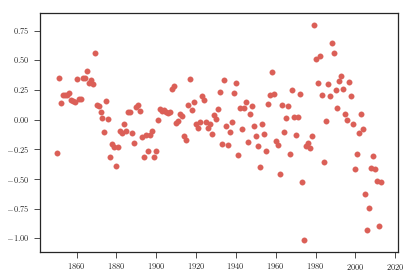

In [201]:
plt.scatter(djf_df.year, e_djf)

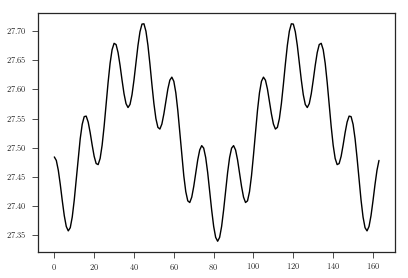

In [202]:
# fitted seasonal cycle
#+ k_hat_djf[8]*cos8_djf +\
f_hat_djf = k_hat_djf[0] + k_hat_djf[4]*cos2_djf + k_hat_djf[8]*cos11_djf
plt.plot(f_hat_djf,'k-')

In [203]:
# Remove residuals and subtract mean for second order residuals: R^2
resid2_djf = residuals['DJF'] - f_hat_djf
resid2_djf = resid2_djf - np.mean(resid2_djf)

<Container object of 3 artists>

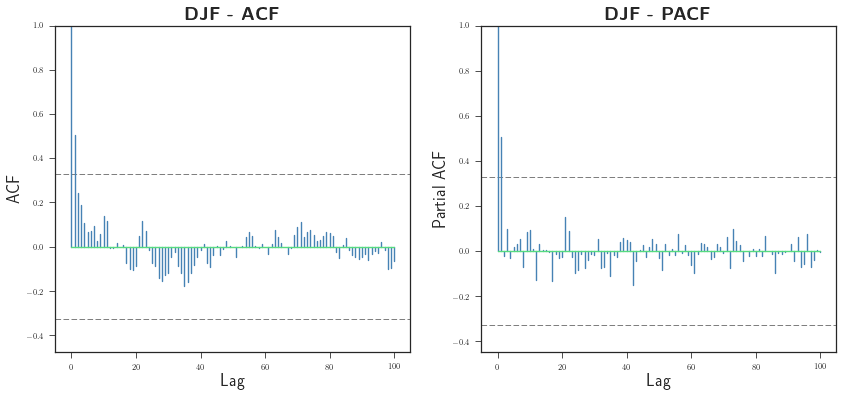

In [204]:
f, axs = plt.subplots(1, 2, figsize=(14,6))

plot_acf(resid2_djf, nlags=100, col=cmap['DJF'], ax=axs[0], title='DJF - ACF')
plot_pacf(resid2_djf, nlags=100, col=cmap['DJF'], ax=axs[1], title='DJF - PACF')

#f.savefig('/home/hflores/repos/kaust_presentation/djf_acf.eps', format='eps', 
#          dpi=1200, bbox_inches='tight')

In [205]:
# Fit AR2 model for R^2
fit1_djf = arima.ARIMA(resid2_djf, (1,0,0)).fit()
fit2_djf = arima.ARIMA(resid2_djf, (2,0,0)).fit()
print(fit1_djf.summary())
print(fit2_djf.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  164
Model:                     ARMA(1, 0)   Log Likelihood                  17.151
Method:                       css-mle   S.D. of innovations              0.218
Date:                Wed, 26 Jul 2017   AIC                            -28.302
Time:                        16:22:26   BIC                            -19.002
Sample:                             0   HQIC                           -24.526
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.035     -0.016      0.987      -0.069       0.068
ar.L1.y        0.5155      0.067      7.650      0.000       0.383       0.648
                                    Roots           

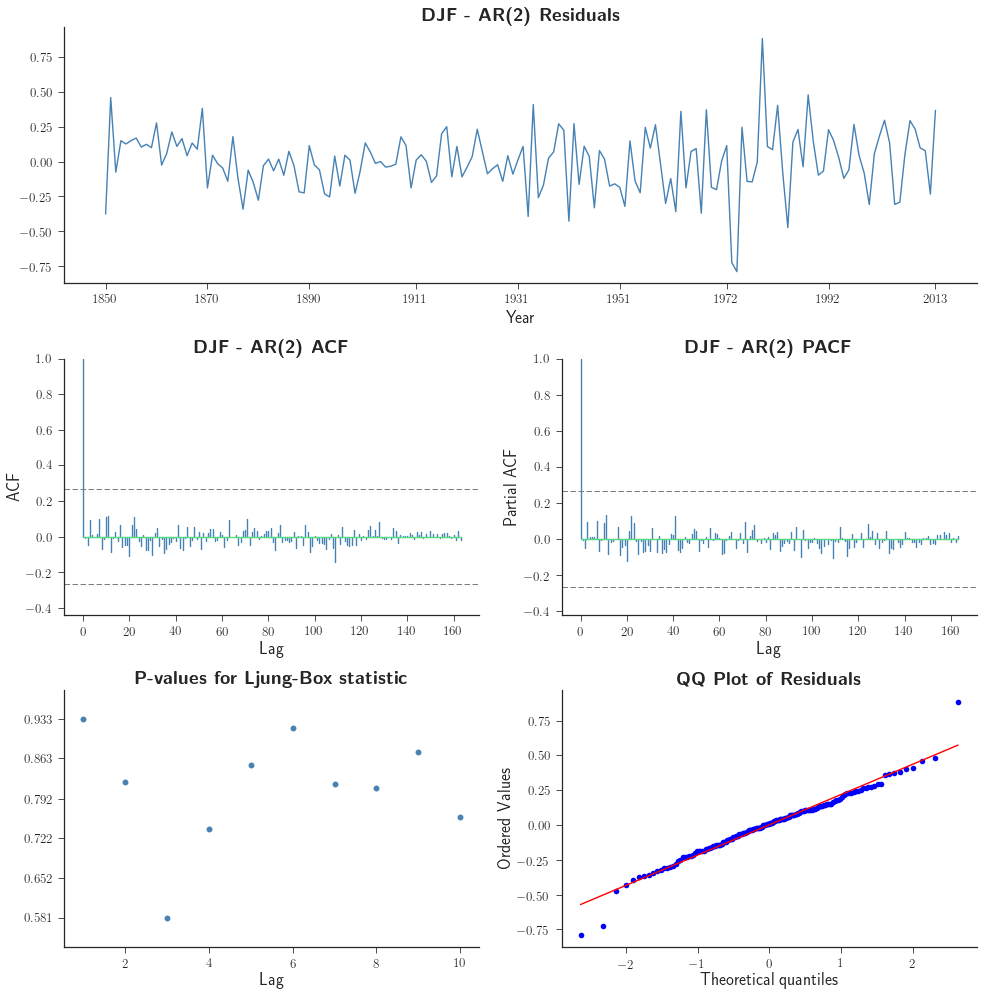

In [207]:
e_ar_djf = ts_diagnostics(fit2_djf, col=cmap['DJF'], title='DJF - AR(2)', save='djf_res')
#e_ar_djf = ts_diagnostics(fit2_djf, title='DJF', save='djf_res')

In [208]:
ks_djf = scipy.stats.kstest(e_ar_djf, cdf='norm')
ks_djf

KstestResult(statistic=0.32818477647968169, pvalue=2.2204460492503131e-16)

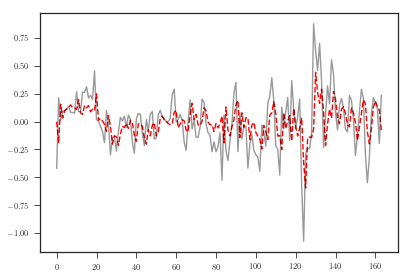

In [209]:
djf_predict = fit2_djf.predict()

plt.plot(djf_predict, 'r--')
plt.plot(residuals['DJF'], color='k', alpha=0.4)

# MAM

In [210]:
periodograms['MAM'].argsort()[-5:][::-1]

array([13, 19,  7, 12,  2])

In [211]:
y_mam = mam_df.seaice_conc.values
sin2_mam = np.array([np.sin(2*np.pi * 2 * (t/nyrs)) for t in np.arange(nyrs)])
cos2_mam = np.array([np.cos(2*np.pi * 2 * (t/nyrs)) for t in np.arange(nyrs)])

sin13_mam = np.array([np.sin(2*np.pi * 13 * (t/nyrs)) for t in np.arange(nyrs)])
cos13_mam = np.array([np.cos(2*np.pi * 13 * (t/nyrs)) for t in np.arange(nyrs)])

sin19_mam = np.array([np.sin(2*np.pi * 19 * (t/nyrs)) for t in np.arange(nyrs)])
cos19_mam = np.array([np.cos(2*np.pi * 19 * (t/nyrs)) for t in np.arange(nyrs)])

sin12_mam = np.array([np.sin(2*np.pi * 12 * (t/nyrs)) for t in np.arange(nyrs)])
cos12_mam = np.array([np.cos(2*np.pi * 12 * (t/nyrs)) for t in np.arange(nyrs)])

sin7_mam = np.array([np.sin(2*np.pi * 7 * (t/nyrs)) for t in np.arange(nyrs)])
cos7_mam = np.array([np.cos(2*np.pi * 7 * (t/nyrs)) for t in np.arange(nyrs)])

In [212]:
fit_mam = smf.glm(
    'y_mam ~ sin2_mam + cos2_mam + \
    sin13_mam + cos13_mam + \
    sin19_mam + cos19_mam + \
    sin12_mam + cos12_mam + \
    sin7_mam + cos7_mam', data=mam_df).fit()
fit_mam.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  y_mam   No. Observations:                  164
Model:                            GLM   Df Residuals:                      153
Model Family:                Gaussian   Df Model:                           10
Link Function:               identity   Scale:                  0.129672094336
Method:                          IRLS   Log-Likelihood:                -59.508
Date:                Wed, 26 Jul 2017   Deviance:                       19.840
Time:                        16:23:13   Pearson chi2:                     19.8
No. Iterations:                     2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.6198      0.028    982.242      0.000      27.565      27.675
sin2_mam       0.0907      0.040      2.280      0.023       0.013       0.169
cos2_mam      -0.3030      0.040     -7.619      0.000      -0.381      -0.225
sin13_mam      0.1019      0.040      2.563      0.010       0.024       0.180
cos13_mam     -0.0148      0.040     -0.371      0.711      -0.093       0.063
sin19_mam      0.0055      0.040      0.139      0.890      -0.072       0.083
cos19_mam      0.0874      0.040      2.197      0.028       0.009       0.165
sin12_mam     -0.0749      0.040     -1.884      0.060      -0.153       0.003
cos12_mam      0.0170      0.040      0.426      0.670      -0.061       0.095
sin7_mam      -0.0598      0.040     -1.505      0.132      -0.138       0.018
cos7_mam       0.0003      0.040      0.007      0.994      -0.078       0.078
==============================================================================
"""

In [213]:
# Check pvalues for coefficients
fit_mam.pvalues

Intercept    0.000000e+00
sin2_mam     2.257926e-02
cos2_mam     2.546955e-14
sin13_mam    1.038247e-02
cos13_mam    7.106816e-01
sin19_mam    8.896898e-01
cos19_mam    2.799880e-02
sin12_mam    5.951241e-02
cos12_mam    6.699016e-01
sin7_mam     1.324512e-01
cos7_mam     9.940956e-01
dtype: float64

In [214]:
print(fit_mam.params)
k_hat_mam = fit_mam.params.values  # extract fitted regression coefficients
e_mam = fit_mam.resid_response    # extract raw residuals

Intercept    27.619764
sin2_mam      0.090686
cos2_mam     -0.302999
sin13_mam     0.101914
cos13_mam    -0.014751
sin19_mam     0.005515
cos19_mam     0.087379
sin12_mam    -0.074935
cos12_mam     0.016952
sin7_mam     -0.059829
cos7_mam      0.000294
dtype: float64


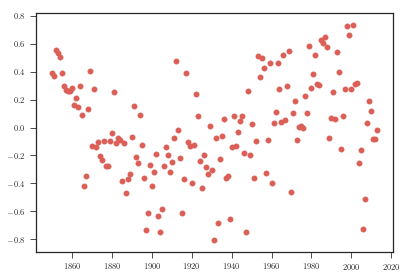

In [215]:
plt.scatter(mam_df.year, e_mam)

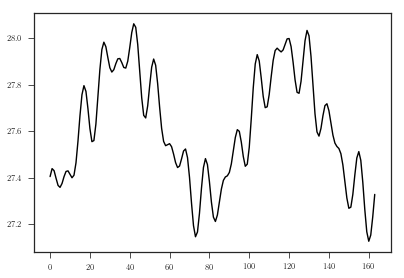

In [216]:
# fitted seasonal cycle
f_hat_mam = k_hat_mam[0] + k_hat_mam[1]*sin2_mam + k_hat_mam[2]*cos2_mam +\
            k_hat_mam[3]*sin13_mam + k_hat_mam[6]*cos19_mam
plt.plot(f_hat_mam,'k-')

In [217]:
# Remove residuals and subtract mean for second order residuals: R^2
resid2_mam = residuals['MAM'] - f_hat_mam
resid2_mam = resid2_mam - np.mean(resid2_mam)

<Container object of 3 artists>

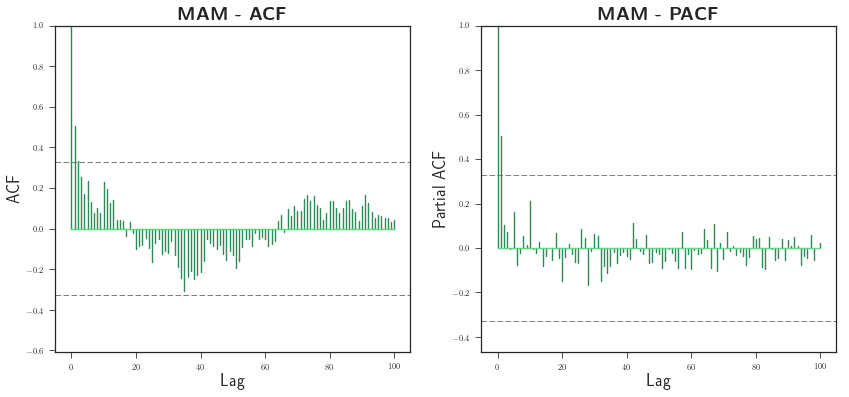

In [218]:
f, axs = plt.subplots(1, 2, figsize=(14,6))

plot_acf(resid2_mam, nlags=100, col=cmap['MAM'], ax=axs[0], title='MAM - ACF')
plot_pacf(resid2_mam, nlags=100, col=cmap['MAM'], ax=axs[1], title='MAM - PACF')

#f.savefig('/home/hflores/repos/kaust_presentation/mam_acf.eps', format='eps', 
#          dpi=1200, bbox_inches='tight')

In [219]:
# Fit AR2 model for R^2
ar1_mam = arima.ARIMA(resid2_mam, (1,0,0)).fit()
ar2_mam = arima.ARIMA(resid2_mam, (2,0,0)).fit()
ar3_mam = arima.ARIMA(resid2_mam, (3,0,0)).fit()
arma21_mam = arima.ARIMA(resid2_mam, (2,0,1)).fit()

print(ar1_mam.summary())
print(ar2_mam.summary())
print(ar3_mam.summary())
print(arma21_mam.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  164
Model:                     ARMA(1, 0)   Log Likelihood                 -28.533
Method:                       css-mle   S.D. of innovations              0.288
Date:                Wed, 26 Jul 2017   AIC                             63.067
Time:                        16:23:44   BIC                             72.366
Sample:                             0   HQIC                            66.842
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0042      0.046      0.093      0.926      -0.085       0.094
ar.L1.y        0.5098      0.067      7.559      0.000       0.378       0.642
                                    Roots           

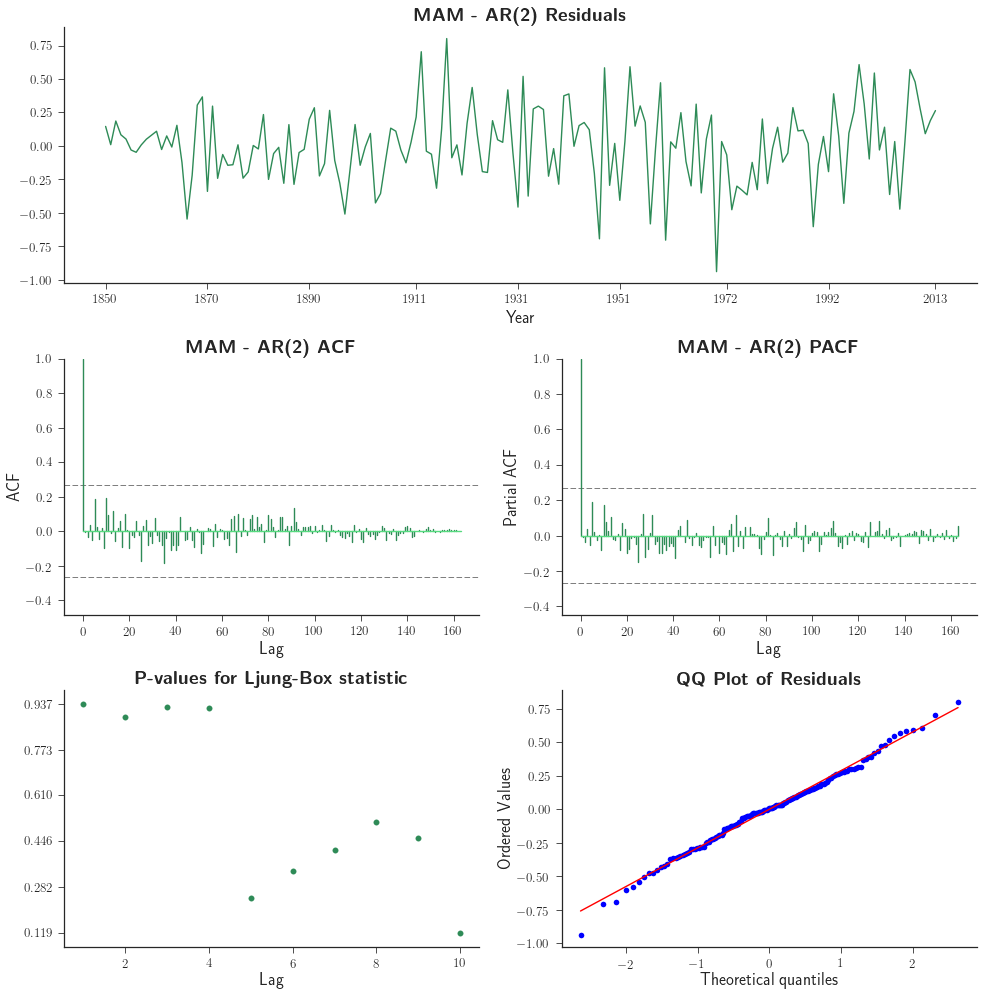

In [221]:
e_mam = ts_diagnostics(ar2_mam, col=cmap['MAM'], title='MAM - AR(2)', save='mam_res')
#e_mam = ts_diagnostics(fit2_mam, title='MAM', save='mam_res')

In [620]:
ks_mam = scipy.stats.kstest(e_mam, cdf='norm')
ks_mam

KstestResult(statistic=0.27932264823955477, pvalue=8.2949203061843946e-12)

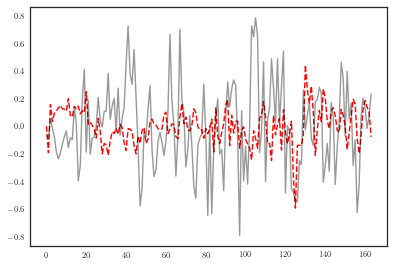

In [327]:
mam_predict = fit2_djf.predict()

plt.plot(mam_predict, 'r--')
plt.plot(residuals['MAM'], color='k', alpha=0.4)